# Machine Learning Explainability
Before a model is released into production, technical & business stakeholders are interested in whether the model's outputs can be trusted. D

Here are some common reasons why machine learning explainability & interpretability has been a hot area of research recently:

+ **Regulation**: In some industries, there is legal regulation which requires machine learning models to be approved prior to being used in production. 
  +  For example, when a bank or credit card provider rejects an applicant for credit, they are legally responsible to provide an explanation for why a prediction was made.
  
+ **Danger of Black Box Models**: If we don't know how a machine learning model has learned to make predictions, how can we trust that it's output isn't **biased** or **unfair**.
  +  For example, when a bank or credit card provider rejects an applicant for credit, how can we ensure that it didn't arrive at that outcome due to some bias against protected class (such as gender, ethnicity, age, sexual orientation etc). 

+ **Safety**: Would you trust sharing the road with a self driving car whose machine learning algorithm is unknown or difficult to explain?
  + Machine learning in the following industries care about safety including but not limited to Transportation, Security, Medicine, Finance, Legal & Military organizations.
 
DARPA launched an an initiative called [XAI](https://www.darpa.mil/program/explainable-artificial-intelligence) to ensure machine learning models are explainable and could be understood by humans.

![alt text](../assets/images/XAI_diagram.png)

There are a variety of resources online which provide both academic and industry recommendations for machine learning explainability and interpretability. 

[H2O](https://github.com/h2oai/mli-resources) provides some practical examples along with some best practices to get you started with machine learning model explainability.

#### References

* [Towards A Rigorous Science of Interpretable Machine Learning](https://arxiv.org/pdf/1702.08608.pdf)
* [Ideas for Machine Learning Interpretability](https://www.oreilly.com/ideas/ideas-on-interpreting-machine-learning)
* [Fairness, Accountability, and Transparency in Machine Learning (FAT/ML) Scholarship](https://www.fatml.org/resources/relevant-scholarship)
* [Explaining Explanations: An Approach to Evaluating Interpretability of Machine Learning](https://arxiv.org/pdf/1806.00069.pdf)
* [A Survey Of Methods For Explaining Black Box Models](https://arxiv.org/pdf/1802.01933.pdf)
* [Trends and Trajectories for Explainable, Accountable and Intelligible Systems: An HCI Research Agenda](https://dl.acm.org/citation.cfm?id=3174156)
* [Interpretable Machine Learning by Christoph Molnar](https://github.com/christophM/interpretable-ml-book)


#### Techniques

* **Partial Dependence**: [*Elements of Statistical Learning*](https://web.stanford.edu/~hastie/ElemStatLearn/printings/ESLII_print12.pdf)
* **LIME**: [“Why Should I Trust You?” Explaining the Predictions of Any Classifier](http://www.kdd.org/kdd2016/papers/files/rfp0573-ribeiroA.pdf)
* **LOCO**: [Distribution-Free Predictive Inference for Regression](http://www.stat.cmu.edu/~ryantibs/papers/conformal.pdf)
* **ICE**: [Peeking inside the black box: Visualizing statistical learning with plots of individual conditional expectation](https://arxiv.org/pdf/1309.6392.pdf)
* **Surrogate Models**
  * [Extracting tree structured representations of trained networks](https://papers.nips.cc/paper/1152-extracting-tree-structured-representations-of-trained-networks.pdf)
  * [Interpreting Blackbox Models via Model Extraction](https://arxiv.org/pdf/1705.08504.pdf)
* **Shapely Explanations**: [A Unified Approach to Interpreting Model Predictions](http://papers.nips.cc/paper/7062-a-unified-approach-to-interpreting-model-predictions)
* **Anchors**: [Anchors: High-Precision Model-Agnostic Explanations](https://homes.cs.washington.edu/~marcotcr/aaai18.pdf) 


## Tree ensemble example with TreeExplainer 
The following [blog post](https://towardsdatascience.com/interpretable-machine-learning-with-xgboost-9ec80d148d27
) by Scott Lundberg (author of SHAP) demonstrates a practical example to help us get started.

There is a well understood tradeoff between model accuracy vs explainability. 
![alt text](../assets/images/model_acc_vs_exp.png)

The diagram above illustrates accuracy comes at the cost of explainability & vice versa. For example, linear models & decision trees are easily explainable but may not be the most predictive. Neural Nets on the other hand provide great predictive power often at the cost of interpretability. 

Companies like [ZestFinance](https://www.zestfinance.com/zaml) provide a suite of explainabilty tools which help leverage state of the art machine learning while not having to sacrifise predictive power. 

Earlier in the course, we developed a XGBoost model to predict whether a particular flight will be delayed or not. Let's start off by loading our model artifact we previously saved...

In [1]:
import logging, xgboost as xgb, numpy as np
from sklearn.metrics import mean_absolute_error
import joblib
import pandas as pd
from datetime import datetime
import pickle
import time
import shap
# load JS visualization code to notebook
shap.initjs()
import matplotlib.pyplot as plt
plt.show(block=True)

training_examples = pd.read_pickle("../data/processed/airlines_training_examples.pkl")
f1=open("../data/processed/airlines_training_targets.pkl",'rb')
training_targets = pickle.load(f1) 
f1.close()
test_examples = pd.read_pickle("../data/processed/airlines_test_examples.pkl")

def get_train_points():
     return training_examples.values.tolist()

def get_test_points(start_row_index,end_row_index):
    return test_examples.iloc[start_row_index:end_row_index].values.tolist()

def get_test_point(row_index):
     return test_examples.iloc[row_index].tolist()
    
# Create a training matrix.
dtrain = xgb.DMatrix(get_train_points(), label=training_targets)
# We then create parameters, watchlist, and specify the number of rounds
# This is code that we use to build our XGBoost Model, and your code may differ.
param = {'max_depth': 2, 'eta': 1, 'silent': 1, 'objective': 'binary:logistic'}
watchlist = [(dtrain, 'train')]
num_round = 2
model = xgb.train(param, dtrain, num_round, watchlist)

[0]	train-error:0.379255
[1]	train-error:0.374415


### Global Feature Importance
XGBoost provides a `plot_importance()` [method](https://xgboost.readthedocs.io/en/latest/python/python_api.html) which returns a list of features and their relative importance for the learned model according to the following options:

+ **Weight**: The number of times a feature is used to split the data across all trees.

+ **Cover**: The number of times a feature is used to split the data across all trees weighted by the number of training data points that go through those splits.

+ **Gain**: The average training loss reduction gained when using a feature for splitting.

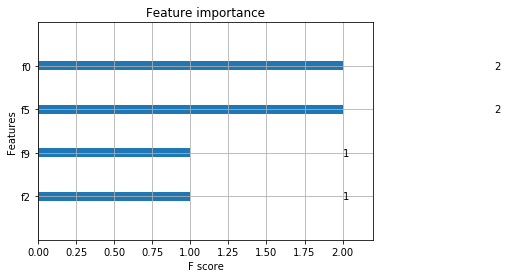

In [2]:
xgb.plot_importance(model,importance_type='weight')

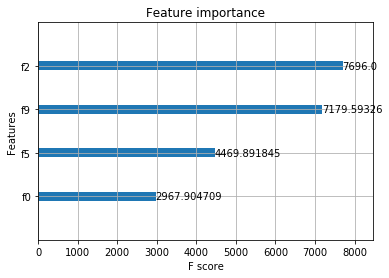

In [3]:
xgb.plot_importance(model,importance_type='cover')

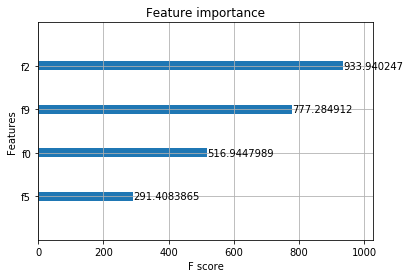

In [4]:
xgb.plot_importance(model,importance_type='gain')

Notice the output of `plot_importance()` changes depending on the **importance_type** used. Notice that `Year` feature was most important when using `weight` while `DayofMonth` feature is more important while using `cover` & `gain`.

Which of the these three outputs should we use? Is one more correct than the other? Is one more right in some circumstances while another is right for other use cases?

### What makes a metric for feature importance good or bad?
Scott Lundberg [suggests](https://towardsdatascience.com/interpretable-machine-learning-with-xgboost-9ec80d148d27) the two most important properties for any good feature attribution method should follow:

1. **Consistency**: Whenever we change a model such that it relies more on a feature, then the attributed importance for that feature should not decrease.

2. **Accuracy**: The sum of all the feature importances should sum up to the total importance of the model. 

Based on a proof from Game Theory, this NIPS paper titled [A Unified Approach to Interpreting Model Predictions](http://papers.nips.cc/paper/7062-a-unified-approach-to-interpreting-model-predictions) presents how **SHAP (SHapley Additive exPlanations)** is a unified approach to explain the output of any machine learning model. SHAP connects game theory with local explanations, uniting several previous methods and representing the only possible consistent and locally accurate additive feature attribution method based on expectations

We are now interested in SHAP can explain the output of any machine learning model developed using XGBoost/LightGBM/CatBoost/scikit-learn. 

Please refer to the following for additional information

+ [Tree SHAP arXiv paper](https://arxiv.org/abs/1802.03888) paper for more details regarding tree ensemble methods.

+ [SHAP Documentation](https://shap.readthedocs.io/)

### Example Specific Attribution
All of the feature importance methods described above are global, meaning it's true for a certain group of flights. SHAP provides example specific feature attributions (i.e. for a given flight).

In [5]:
# explain the model's predictions using SHAP values
# (same syntax works for LightGBM, CatBoost, and scikit-learn models)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(dtrain)
shap_values

array([[ 0.33381692,  0.        , -0.18202336, ...,  0.        ,
         0.        ,  0.        ],
       [-0.39352766,  0.        , -0.28832218, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.33381692,  0.        , -0.18202336, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.39352766,  0.        , -0.28832218, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.33381692,  0.        , -0.08579841, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.33381692,  0.        , -0.18202336, ...,  0.        ,
         0.        ,  0.        ]], dtype=float32)

In [6]:
print("Number of rows: ", len(shap_values))
print("Number of columns: ", len(shap_values[0]))

Number of rows:  30784
Number of columns:  286


The `shap_values()` method returns an (array of arrays) approximate SHAP values for the model applied to feature in the training data set. In other words, each row is an array where each element represents the SHAP feature attribution value. 

In [7]:
shap_values[0]

array([ 0.33381692,  0.        , -0.18202336,  0.        ,  0.        ,
        0.27681857,  0.        ,  0.        ,  0.        , -0.04504164,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.  

In [8]:
# visualize the first prediction's explanation
shap.force_plot(explainer.expected_value, shap_values[0,:], training_examples.iloc[0,:])

The above explanation shows features each contributing to push the model output from the base value (the average model output over the training dataset we passed) to the model output. Features pushing the prediction higher are shown in red, those pushing the prediction lower are in blue.

For our model, a flight which is delayed contains a target value of 1, otherwise it's on time denoted by 0. The visualization above suggests the first row in our dataset contains `CRSDepTime=1831 (Scheduled Departure Time)` & `CRSArrTime=2012 (Scheduled Arrival Time)` features in red (i.e. pushing model higher towards a score of 1). This is consistent with our intiution that those two features are highly correlated with one another and suggest flight will be delayed if the value increases.

Features in blue such as `DayOfWeek=2` & `DayofMonth=25` positively correlate with a flight being delayed.

In [9]:
shap.force_plot(explainer.expected_value, shap_values[5,:], training_examples.iloc[5,:])

Similarily, the features in blue positively correlate with a flight being delayed.

The above explanation shows features each contributing to push the model output from the base value (the average model output over the training dataset we passed) to the model output. Features pushing the prediction higher are shown in red, those pushing the prediction lower are in blue.

In [10]:
# visualize the training set predictions
shap.force_plot(explainer.expected_value, shap_values[:5], training_examples.iloc[0:5, :])

To get an overview of which features are most important for a model we can plot the SHAP values of every feature for every sample. The plot below sorts features by the sum of SHAP value magnitudes over all samples, and uses SHAP values to show the distribution of the impacts each feature has on the model output. The color represents the feature value (red high, blue low). 

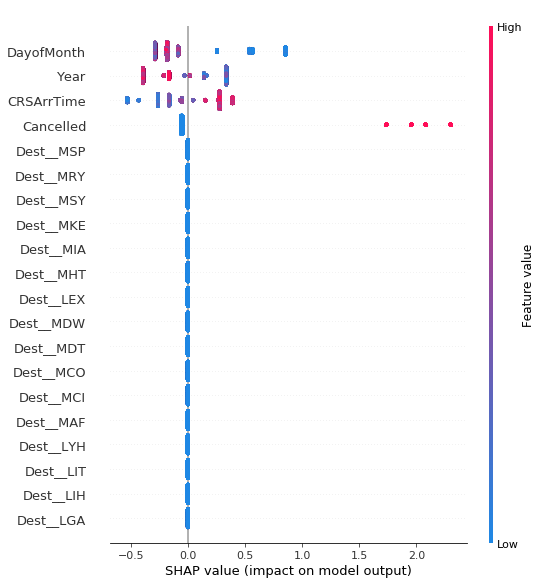

In [11]:
shap.summary_plot(shap_values, training_examples)

We can also just take the mean absolute value of the SHAP values for each feature to get a standard bar plot (produces stacked bars for multi-class outputs):

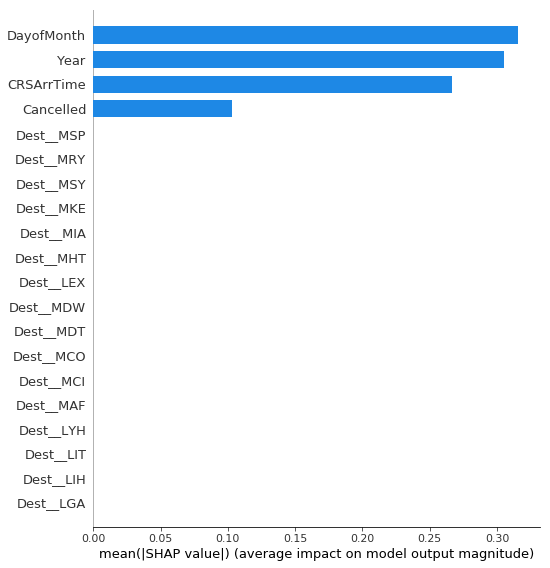

In [12]:
shap.summary_plot(shap_values, training_examples, plot_type="bar")